## Importing Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.style as style
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score

## Loading Datasets

In [2]:
train=pd.read_csv("E:\\Kaggel compitiion\\House Prices Advanced Regression Techniques\\After analizing\\train.csv")
test=pd.read_csv("E:\\Kaggel compitiion\\House Prices Advanced Regression Techniques\\After analizing\\test.csv")

## Feature Selection

In [3]:
test=test.drop('Id',axis=1)
train=train.drop('Id',axis=1)

In [4]:
"""To make normalize"""
train["SalePrice"]=np.log(train["SalePrice"])

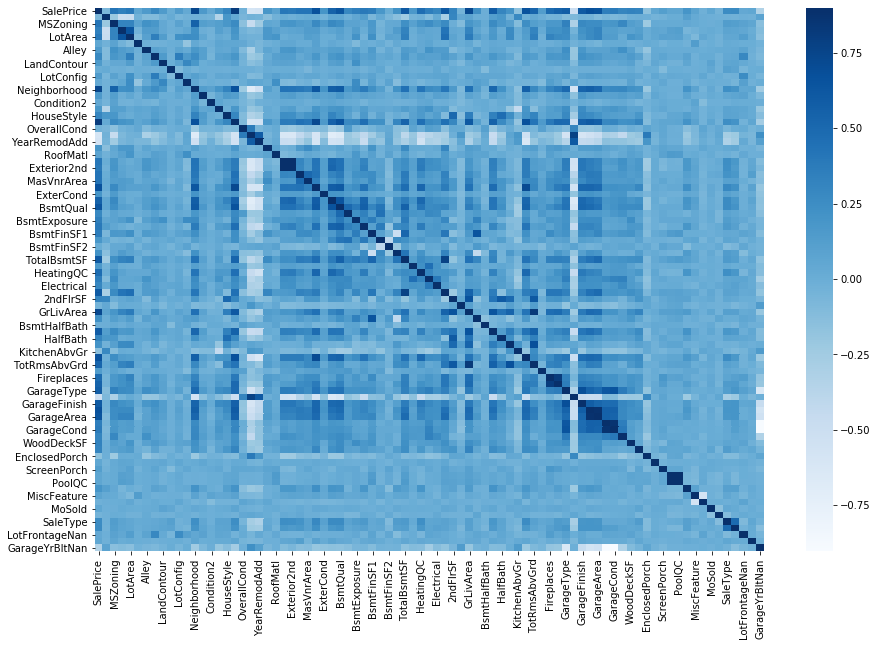

SalePrice       1.000000
OverallQual     0.814790
Neighborhood    0.738713
GrLivArea       0.729287
GarageCars      0.680087
ExterQual       0.674023
KitchenQual     0.664368
GarageArea      0.649467
BsmtQual        0.645681
TotalBsmtSF     0.608866
1stFlrSF        0.607470
GarageFinish    0.605819
FullBath        0.593850
GarageType      0.577759
Foundation      0.550097
FireplaceQu     0.545347
TotRmsAbvGrd    0.531796
YearRemodAdd   -0.569453
YearBuilt      -0.588775
Name: SalePrice, dtype: float64

In [5]:
cor = train.corr()
plt.figure(figsize=(15,10))
sb.heatmap(cor,cmap="Blues", vmax=0.9)
plt.show()
cor[abs(cor['SalePrice'].values) >= 0.5]['SalePrice'].sort_values(ascending=False)

Text(0, 0.5, 'SalePrice')

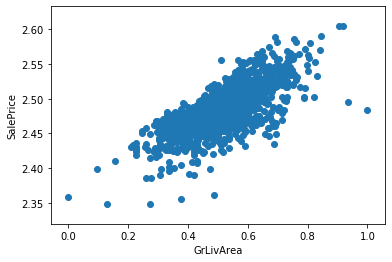

In [6]:
plt.scatter(train["GrLivArea"], train["SalePrice"])
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")

In [7]:
train=train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<12.5)].index)
train.reset_index(drop = True, inplace = True)

Text(0.5, 1, 'Heatmap of all the Features')

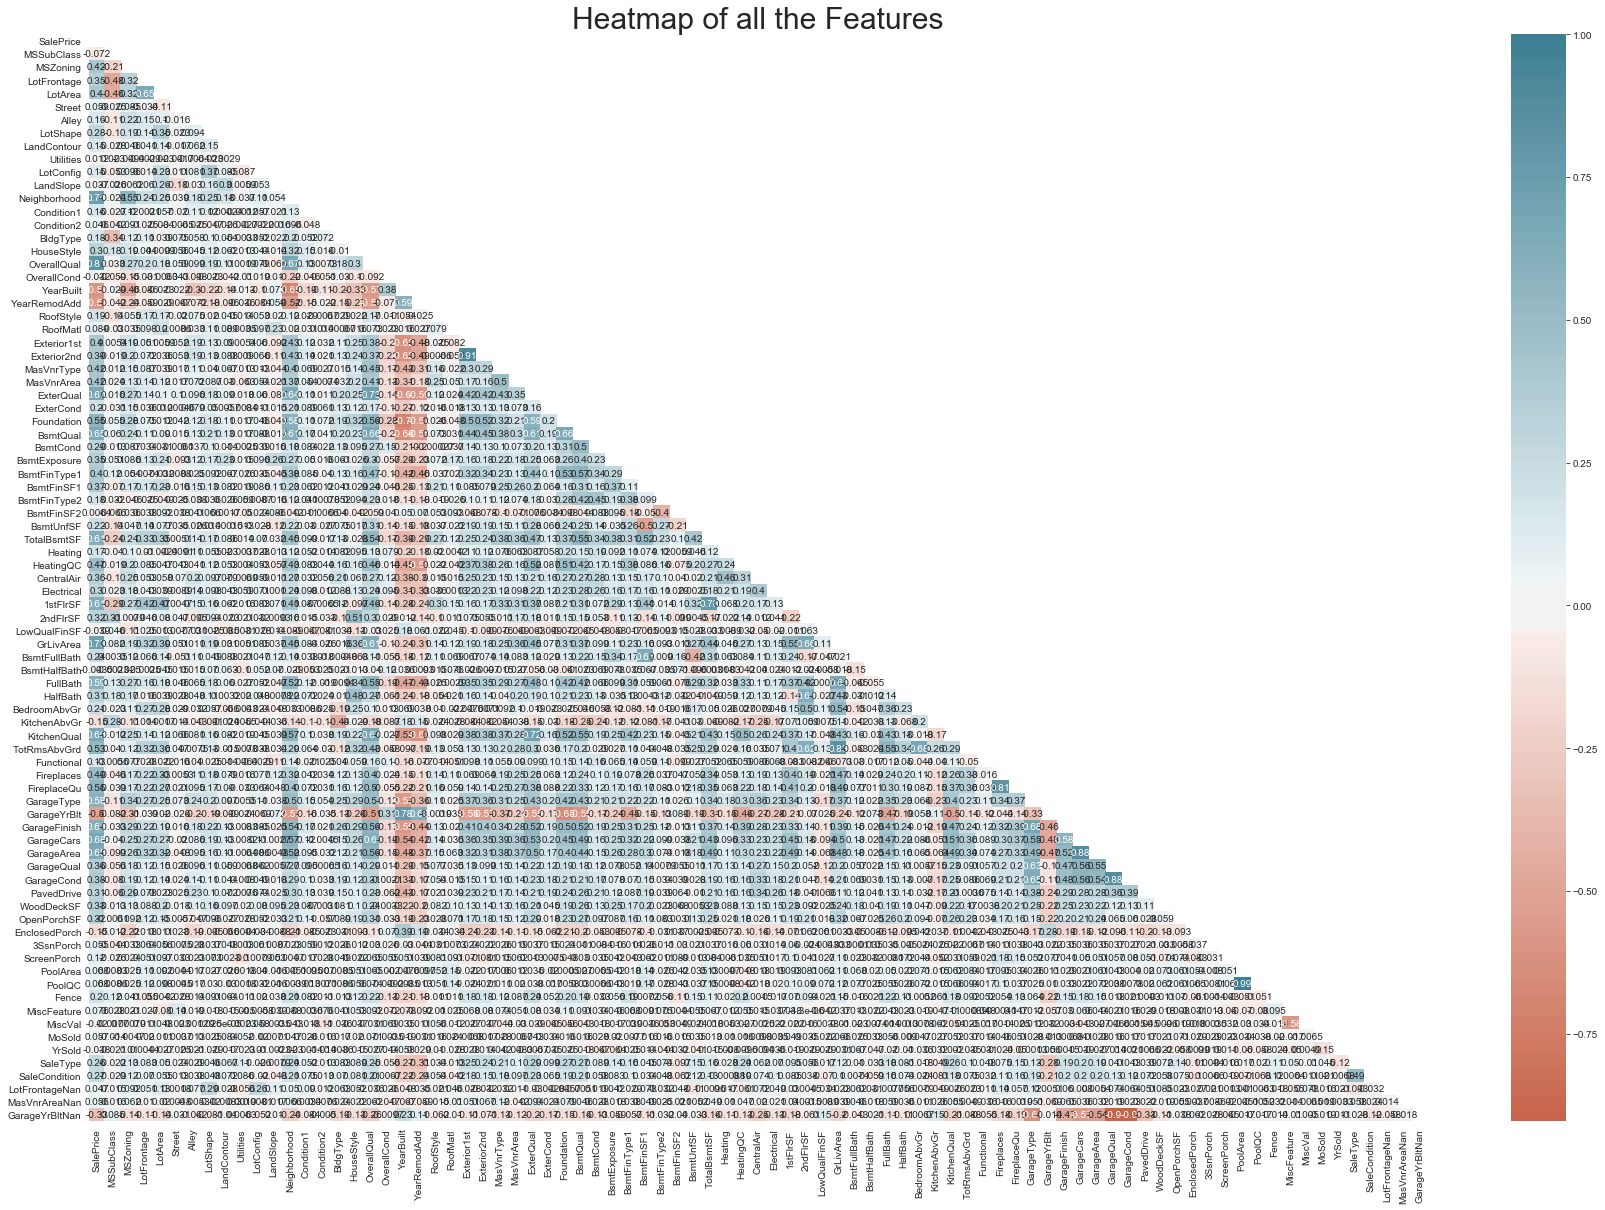

In [8]:
style.use('ggplot')
sb.set_style('whitegrid')
plt.subplots(figsize = (30,20))
#Plotting heatmap. 
#Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(train.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sb.heatmap(train.corr(), cmap=sb.diverging_palette(20, 220, n=200), mask = mask, annot=True, center = 0, );
plt.title("Heatmap of all the Features", fontsize = 30)

## Missing Value

In [9]:
data=pd.concat((train,test)).reset_index(drop=True)

In [10]:
#Total Missing Values
total_missing=data.isnull().sum().sort_values(ascending = False)
percent_missing=((data.isnull().sum()/data.isnull().count())*100).sort_values(ascending = False)
missing=pd.concat([total_missing,percent_missing],axis=1,keys=["Total","%"])
missing

,Total,%
BsmtHalfBathNan,1460,50.017129
BsmtFullBathNan,1460,50.017129
SalePrice,1459,49.982871
TotalBsmtSF,1,0.034258
BsmtUnfSF,1,0.034258
...,...,...
TotRmsAbvGrd,0,0.000000
Functional,0,0.000000
Fireplaces,0,0.000000
FireplaceQu,0,0.000000


In [11]:
# Diffrencing categorial and int
data_categorical=data.select_dtypes("O")
data_int=data.select_dtypes(["int64","float64"])

In [12]:
#Missing value in categorical
k=data_categorical.isnull().sum().sort_values(ascending=False)
cat_column1=[i for i in k.index if k[i]>4]
for i in cat_column1:    
    data_categorical[i].fillna("None",inplace=True)

cat_column2=[i for i in k.index if k[i]<=4 and k[i]>0]
for i in cat_column2:
    data_categorical[i].fillna(data[i].mode()[0],inplace = True)

In [13]:
#Missing value in int
k1=data_int.isnull().sum().sort_values(ascending=False)
k1=k1.drop("SalePrice")
int_column1=[i for i in k1.index]

for i in int_column1:
    data_int[i].fillna(0,inplace=True)

In [14]:
df=pd.concat([data_categorical,data_int],axis=1)
df['MSSubClass'] = df['MSSubClass'].apply(str)
df['YrSold'] = df['YrSold'].astype(str)
df['MoSold'] = df['MoSold'].astype(str)
df.drop('SalePrice', axis=1, inplace = True)

In [15]:
#Again Checking any missing value
total_missing=df.isnull().sum().sort_values(ascending = False)
percent_missing=((df.isnull().sum()/df.isnull().count())*100).sort_values(ascending = False)
missing=pd.concat([total_missing,percent_missing],axis=1,keys=["Total","%"])
missing

,Total,%
BsmtHalfBathNan,0,0.0
BsmtCond,0,0.0
Exterior1st,0,0.0
Exterior2nd,0,0.0
MasVnrType,0,0.0
...,...,...
GarageType,0,0.0
GarageYrBlt,0,0.0
GarageFinish,0,0.0
GarageCars,0,0.0


In [16]:
numeric_feats = df.dtypes[df.dtypes != "object"].index
skewed_feats = df[numeric_feats].apply(lambda x: x.skew()).sort_values(ascending=False)
skewed_feats

BsmtHalfBathNan    38.183753
BsmtFullBathNan    38.183753
MiscVal            21.962877
PoolQC             17.005900
PoolArea           16.916985
                     ...    
BsmtFinType2       -1.995208
BldgType           -2.433619
Heating            -8.775226
Street            -15.508104
Utilities         -31.160855
Length: 81, dtype: float64

In [17]:
high_skew = skewed_feats[skewed_feats > 0.5]
skew_index = high_skew.index

In [18]:
# Normalise skewed features
for i in skew_index:
    df[i] = boxcox1p(df[i], boxcox_normmax(df[i] + 1))

In [19]:
#Encoding the finalized features
final_features = pd.get_dummies(df).reset_index(drop=True)
print('Features size:', df.shape)
final_features.head()

Features size: (2919, 84)


,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,MoSold_0.6363636363636364,MoSold_0.7272727272727273,MoSold_0.8181818181818182,MoSold_0.9090909090909092,MoSold_1.0,YrSold_0.0,YrSold_0.25,YrSold_0.5,YrSold_0.75,YrSold_1.0
0,0.75,0.418208,0.366344,1.0,1.0,0.000000,0.273181,1.0,0.00,0.0,...,0,0,0,0,0,0,0,1,0,0
1,0.75,0.495064,0.391317,1.0,1.0,0.000000,0.273181,1.0,0.50,0.0,...,0,0,0,0,0,0,1,0,0,0
2,0.75,0.434909,0.422359,1.0,1.0,0.333333,0.273181,1.0,0.00,0.0,...,0,1,0,0,0,0,0,1,0,0
3,0.75,0.388581,0.390295,1.0,1.0,0.333333,0.273181,1.0,0.25,0.0,...,0,0,0,0,0,1,0,0,0,0
4,0.75,0.513123,0.468761,1.0,1.0,0.333333,0.273181,1.0,0.50,0.0,...,0,0,0,0,1,0,0,1,0,0


## Spliting data to trin and test

In [20]:
nrow_train = train.shape[0]
x_train = final_features[:nrow_train]
x_test = final_features[nrow_train:]
y = train['SalePrice']

## Hyperparameter Tuning

In [21]:
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]

kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

In [22]:
# Kernel Ridge Regression : made robust to outliers
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))

# LASSO Regression : made robust to outliers
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, 
                    alphas=alphas2,random_state=42, cv=kfolds))

# Elastic Net Regression : made robust to outliers
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, 
                         alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))

## Fitting Model

In [23]:
#Fit the training data x_train,y 
elastic_model = elasticnet.fit(x_train, y)
lasso_model = lasso.fit(x_train, y)
ridge_model = ridge.fit(x_train, y)

In [24]:
# model blending function using fitted models to make predictions
def blend_models(X):
    return ((elastic_model.predict(X)) + (lasso_model.predict(X)) + (ridge_model.predict(X)))/3


## Predction

In [25]:
submission = pd.read_csv("E:\\Kaggel compitiion\\House Prices Advanced Regression Techniques\\sample_submission.csv")
submission.iloc[:,1] = np.expm1(blend_models(x_test))

## Fix outleir predictions

In [26]:
q1 = submission['SalePrice'].quantile(0.0045)
q2 = submission['SalePrice'].quantile(0.99)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)

## Saving

In [27]:
submission.to_csv("E:\\Kaggel compitiion\\House Prices Advanced Regression Techniques\\House Price submission.csv", index=False)